# **Predicting Diabetes Risk Using Ensemble Techniques and Explainable Artificial Intelligence**

Applied Physics 157 Final Project \
A.Y 2023 - 2024

**Obtaining dataset**

In [209]:
from ucimlrepo import fetch_ucirepo 
  
#fetch dataset 
early_stage_diabetes_risk_prediction = fetch_ucirepo(id=529) 
  
#data (as pandas dataframes) 
X = early_stage_diabetes_risk_prediction.data.features 
y = early_stage_diabetes_risk_prediction.data.targets 
  
#metadata 
print(early_stage_diabetes_risk_prediction.metadata) 
  
#variable information 
print(early_stage_diabetes_risk_prediction.variables) 

{'uci_id': 529, 'name': 'Early Stage Diabetes Risk Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/529/early+stage+diabetes+risk+prediction+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/529/data.csv', 'abstract': 'This dataset contains the sign and symptpom data of newly diabetic or would be diabetic patient. ', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 520, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Gender'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5VG8H', 'creators': [], 'intro_paper': {'title': 'Likelihood Prediction of Diabetes at Early Stage Using Data Mining Techniques', 'authors': 'M. M. F. Islam, Rahatara Ferdousi, Sadikur Rahman, Humayra Yasmin Bushra', 'published_in': 

## **Import necessary libraries**

In [469]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#For machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

#For explanative AI
import shap

In [558]:
#Concatenate X and y along the columns axis
df = pd.concat([X, y], axis=1)
df = df.drop(columns=['gender'])
display(df)

#Assign values of 1 or 0 to the binary features and target
df['class'] = df['class'].replace({'Positive': 1, 'Negative': 0})
columns_to_replace = df.loc[:, 'polyuria':'obesity'].columns
df[columns_to_replace] = df[columns_to_replace].replace({'Yes': 1, 'No': 0})
#df['gender'] = df['gender'].replace({'Female': 1, 'Male': 0})
df

,age,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


,age,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


**Check for missing data**

In [559]:
missing_data = df.isnull().sum()
print(missing_data)

age                   0
polyuria              0
polydipsia            0
sudden_weight_loss    0
weakness              0
polyphagia            0
genital_thrush        0
visual_blurring       0
itching               0
irritability          0
delayed_healing       0
partial_paresis       0
muscle_stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64


## **Feature correlation**

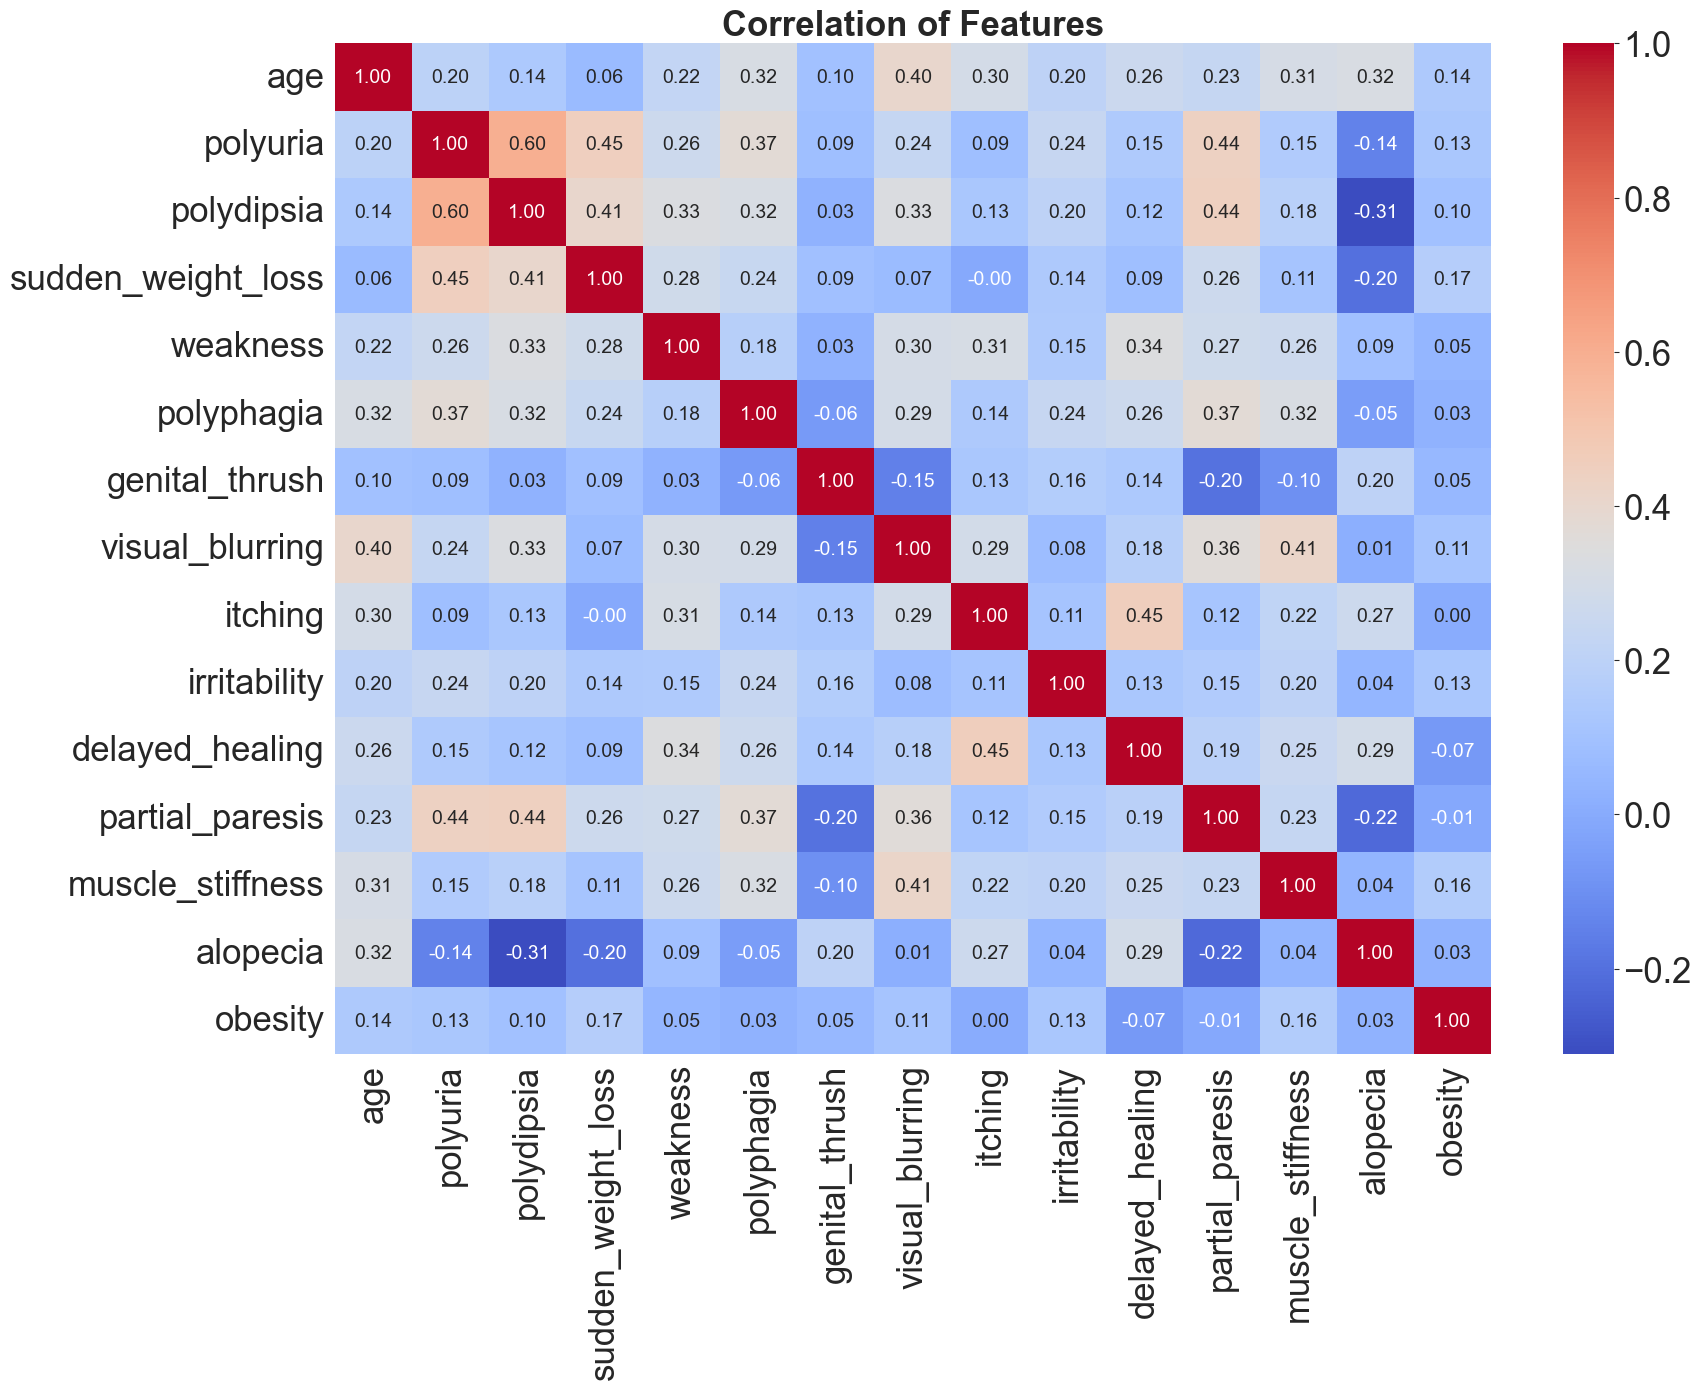

In [560]:
df_subset = df.iloc[:, :-1]

#Compute the correlation matrix
corr = df_subset.corr()

#Plot the correlation matrix using a heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 14})
plt.title('Correlation of Features', fontweight = 'bold')


plt.tight_layout()
plt.savefig('FeatureCorrelation.jpg')
plt.show()

## **Model Training**

In [575]:
#Assign X and y
X_binary = df.loc[:, 'age':'obesity']
y_binary = df.loc[:, 'class']

#Split the data once
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

#Initialize the models
bagging = BaggingClassifier(random_state=42, n_estimators = 1000, bootstrap=True, oob_score = True)
random_forest = RandomForestClassifier(random_state=42, n_estimators = 1000, bootstrap=True, oob_score = True)
xgboost = XGBClassifier(random_state=42, n_estimators = 1000)

#Train the models
bagging.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

#Make predictions
y_pred_bg = bagging.predict(X_test)
y_pred_rf = random_forest.predict(X_test)
y_pred_xgb = xgboost.predict(X_test)

#Out of bag
oob_bg = bagging.oob_score_
oob_rf = random_forest.oob_score_
print("BG Out-of-Bag Accuracy:", oob_bg)
print("RF Out-of-Bag Accuracy:", oob_rf)
#XGBoost does not support out of bag

#Cross validation scores
cv_scores_bg = cross_val_score(bagging, X_train, y_train, cv=5, scoring='accuracy')
mean_bg = np.mean(cv_scores_bg)
print("Mean BG Cross-Validation Score:", mean_bg)
cv_scores_rf = cross_val_score(random_forest, X_train, y_train, cv=5, scoring='accuracy')
mean_rf = np.mean(cv_scores_rf)
print("Mean RF Cross-Validation Score:", mean_rf)
cv_scores_xgb = cross_val_score(xgboost, X_train, y_train, cv=5, scoring='accuracy')
mean_xgb = np.mean(cv_scores_xgb)
print("Mean XGB Cross-Validation Score:", mean_xgb)

#Acurracy
def print_accuracy(f):
    accuracy =  100 * np.sum(f(X_test) == y_test) / len(y_test)
    print(f'Accuracy: {accuracy}%')
    return accuracy

accuracy_bg = print_accuracy(bagging.predict)
accuracy_rf = print_accuracy(random_forest.predict)
accuracy_xgb = print_accuracy(xgboost.predict)

#Classification reports for other statistics
report_bg = classification_report(y_test, y_pred_bg, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)

#Confusion Matrix
cf_bg = confusion_matrix(y_test, y_pred_bg)
cf_rf = confusion_matrix(y_test, y_pred_rf)
cf_xgb = confusion_matrix(y_test, y_pred_xgb)

BG Out-of-Bag Accuracy: 0.9615384615384616
RF Out-of-Bag Accuracy: 0.9759615384615384
Mean BG Cross-Validation Score: 0.9567699368904188
Mean RF Cross-Validation Score: 0.9687894434882386
Mean XGB Cross-Validation Score: 0.9591508892713712
Accuracy: 95.1923076923077%
Accuracy: 96.15384615384616%
Accuracy: 94.23076923076923%


## **Confusion Matrix**

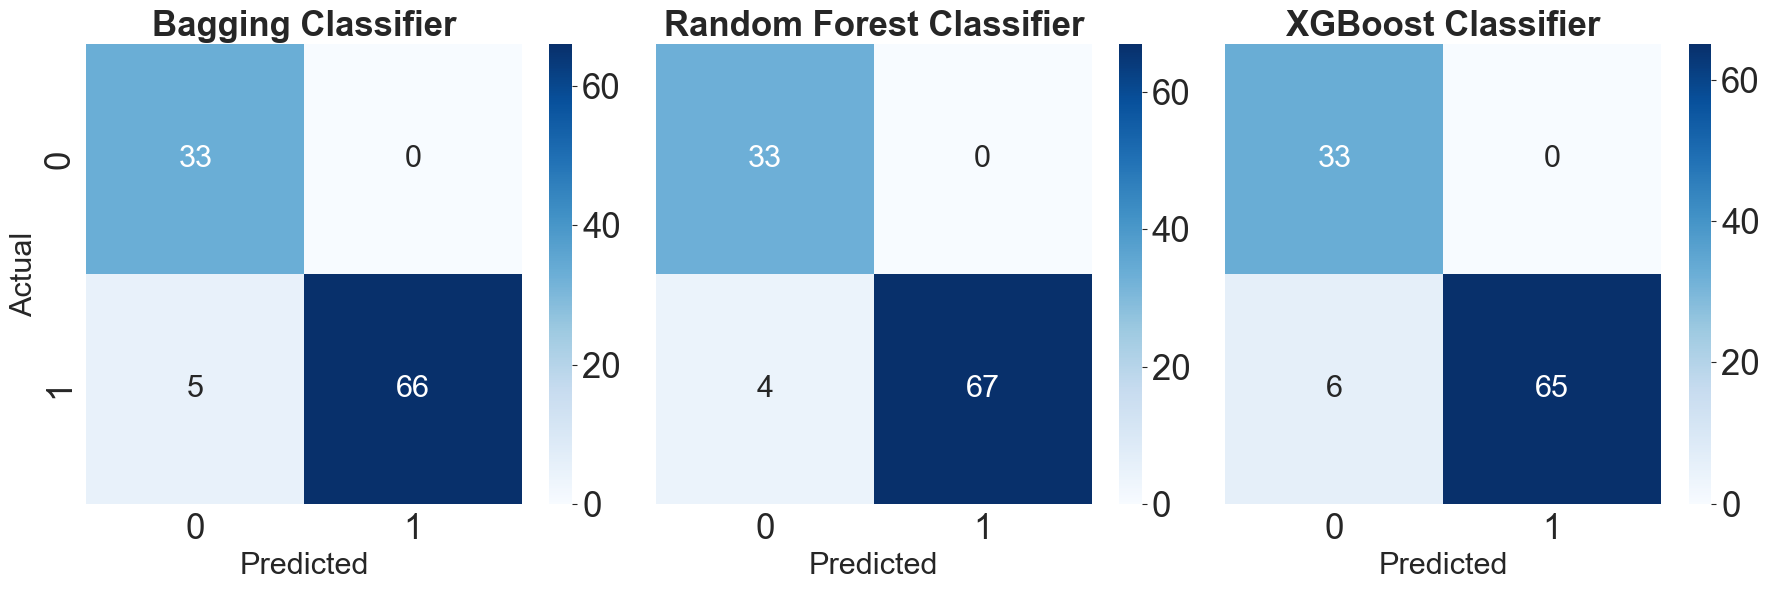

In [562]:
#Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey = True)
fontsize = 22

sns.heatmap(cf_bg, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={"size": 22})
axes[0].set_title('Bagging Classifier', fontweight = 'bold')
axes[0].set_xlabel('Predicted', fontsize = fontsize)
axes[0].set_ylabel('Actual', fontsize = fontsize)

sns.heatmap(cf_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1], annot_kws={"size": 22})
axes[1].set_title('Random Forest Classifier', fontweight = 'bold')
axes[1].set_xlabel('Predicted', fontsize = fontsize)
#axes[1].set_ylabel('Actual', fontsize = fontsize)

sns.heatmap(cf_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[2], annot_kws={"size": 22})
axes[2].set_title('XGBoost Classifier', fontweight = 'bold')
axes[2].set_xlabel('Predicted', fontsize = fontsize)
#axes[2].set_ylabel('Actual', fontsize = fontsize)

#plt.yticks(fontsize = '16')

plt.tight_layout()
plt.savefig('ConfusionMatrix.jpg')
plt.show()

## **Classification Metrics**

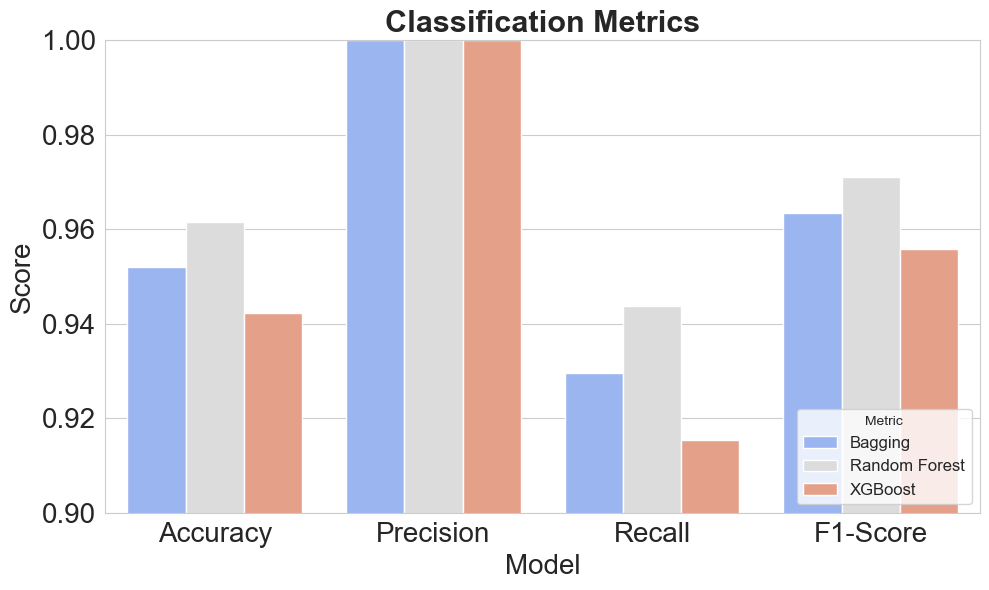

In [563]:
reports = [report_bg, report_rf, report_xgb]

precisions = []
recall = []
f1score = []
accuracies = []

for report in reports:
    precision_class1 = report['1']['precision']
    precisions.append(precision_class1)
    
    recall_class1 = report['1']['recall']
    recall.append(recall_class1)
    
    f1score_class1 = report['1']['f1-score']
    f1score.append(f1score_class1)
    
    accuracy = report['accuracy']
    accuracies.append(accuracy)

#Define the models
models = ['Bagging', 'Random Forest', 'XGBoost']

# Combine the metrics into a DataFrame
df_metrics = pd.DataFrame({'Model': models, 'Accuracy': accuracies, 'Precision': precisions, 'Recall': recall, 'F1-Score': f1score})

# Melt the DataFrame for easier plotting
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot the metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='coolwarm')
plt.xlabel('Model', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.title('Classification Metrics', fontsize=22, fontweight = 'bold')
plt.legend(title='Metric', fontsize=12, loc='lower right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0.9, 1.)
plt.tight_layout()
plt.savefig('ClassificationMetrics.jpg')
plt.show()

In [212]:
sns.set_style('whitegrid')

## **Feature Importance**

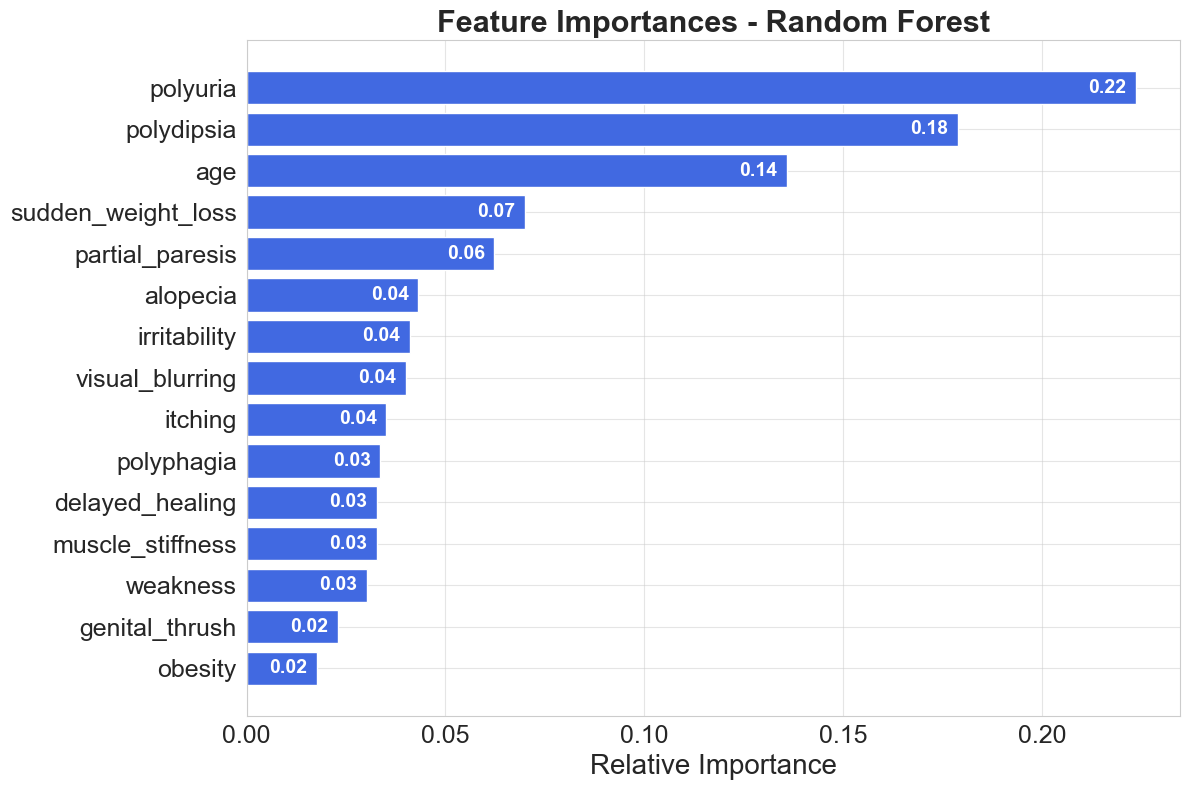

In [564]:
importances = random_forest.feature_importances_
indices = np.argsort(importances)
features = df.columns

#Plotting
plt.figure(figsize=(12, 8))
plt.title('Feature Importances - Random Forest', fontweight='bold', fontsize='22')
plt.barh(range(len(indices)), importances[indices], color='royalblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize = '18')
plt.xticks(fontsize = '18')
plt.xlabel('Relative Importance', fontsize = '20')
plt.grid(alpha = 0.5)

for i, v in enumerate(importances[indices]):
    plt.text(v-0.012, i, f'{v:.2f}', color='white', va='center', fontsize=14, fontweight='bold')
    
plt.tight_layout()
plt.savefig('FeatureImportance.jpg')
plt.show()

## **SHapley Additive Value (SHAP)**

In [577]:
#compute SHAP values
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_binary)

#Mean
shap_values_sum = np.abs(shap_values[:, :, 0])+np.abs(shap_values[:, :, 1])

## **SHAP Summary Plot**

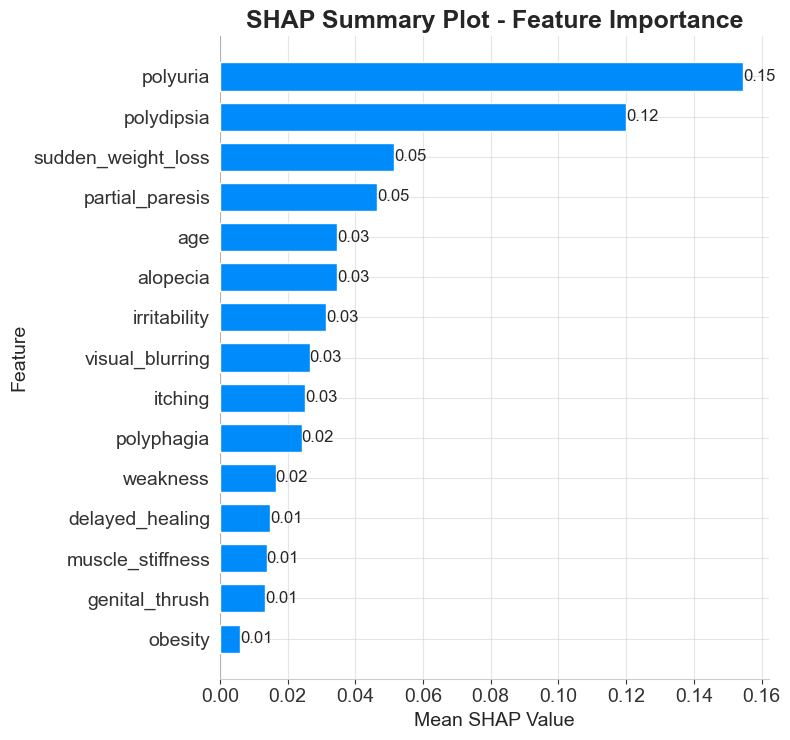

In [567]:
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values[:, :, 1], X_binary.values, plot_type="bar", feature_names=X_binary.columns, show=False)

plt.title('SHAP Summary Plot - Feature Importance', fontsize=18, fontweight='bold')
plt.xlabel('Mean SHAP Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.5)

for i, patch in enumerate(ax.patches):
    ax.text(patch.get_width(), patch.get_y() + patch.get_height() / 2., f'{patch.get_width():.2f}', fontsize=12, ha='left', va='center')

#Show plot
plt.tight_layout()
plt.savefig('SHAPFeature.jpg')
plt.show()

## **SHAP Beeswarm plot**

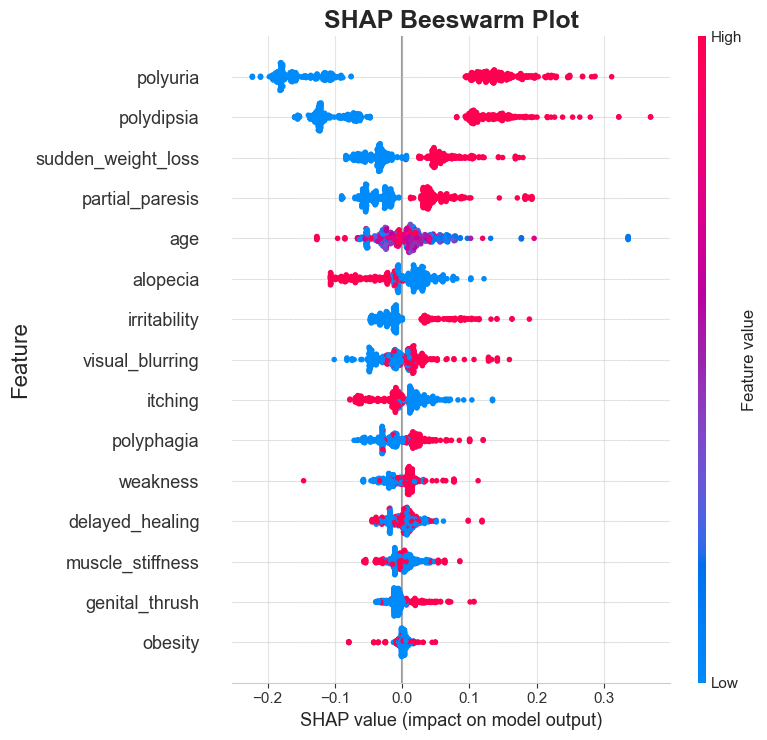

In [572]:
plt.title('SHAP Beeswarm Plot', fontsize=18, fontweight='bold')
plt.xlabel('Mean SHAP Value', fontsize=16)
plt.ylabel('Feature', fontsize=16)

# Customize ticks and grid
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(alpha=0.5)
shap.summary_plot(shap_values[:, :, 1], X_binary.values, feature_names = X_binary.columns, show=False)
plt.tight_layout()
plt.savefig('SHAPBeeswarm.jpg')
plt.show()